In [ ]:
# Cell 1: Imports and constants
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import welch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import joblib

# Configuration
WINDOW = 64  # smaller window = more samples
FS = 256  # Hz
BANDS = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 45)
}


In [ ]:
# Cell 2: Load the data
df = pd.read_csv("../../data/adhdata.csv")
eeg_cols = df.select_dtypes(include=np.number).columns.tolist()
label_col = "Class"
patient_col = "ID"
print(f"Total patients: {df[patient_col].nunique()}")


In [ ]:
# Cell 3: Function to calculate average power for each band
def compute_band_powers(signal, fs=FS):
    freqs, psd = welch(signal, fs=fs, nperseg=fs)
    band_powers = []
    for band in BANDS.values():
        idx = np.logical_and(freqs >= band[0], freqs <= band[1])
        band_powers.append(np.mean(psd[idx]))
    return band_powers


In [ ]:
# Cell 4: Convert all signals into time × features (band powers)
X_all, y_all = [], []
patient_ids = df[patient_col].unique()

for pid in patient_ids:
    patient_df = df[df[patient_col] == pid]
    label = patient_df[label_col].iloc[0]
    signal = patient_df[eeg_cols].values
    features_over_time = []

    for t in range(0, len(signal) - WINDOW + 1, WINDOW):
        segment = signal[t:t + WINDOW]
        all_bands = []
        for ch in range(segment.shape[1]):
            band_powers = compute_band_powers(segment[:, ch])
            all_bands.extend(band_powers)  # 5 bands × #channels
        features_over_time.append(all_bands)

    if features_over_time:
        X_all.append(np.array(features_over_time))
        y_all.append(label)
    else:
        print(f"⚠️ Skipping {pid} (not enough data)")


In [ ]:
# Cell 5: Normalize and pad
flat_X = [x.reshape(-1, x.shape[-1]) for x in X_all]
scaler = StandardScaler()
flat_X_scaled = [scaler.fit_transform(x) for x in flat_X]
joblib.dump(scaler, "scaler_bandpower.pkl")

# Pad to equal time length
X_padded = pad_sequences(flat_X_scaled, padding='post', dtype='float32')

# CNN requires 4D input
X_padded = X_padded[..., np.newaxis]  # (samples, time, features, 1)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_all)


In [ ]:
# Cell 6: Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
print("Train shape:", X_train.shape)
print("Label balance:", np.bincount(y_train))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 166, 93, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 166, 93, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 83, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 83, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 81, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 81, 44, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 40, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 56320)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     3,604,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,623,809 (13.82 MB)

 Trainable params: 3,623,617 (13.82 MB)

 Non-trainable params: 192 (768.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
              precision    recall  f1-score   support

        ADHD       0.55      0.46      0.50        13
     Control       0.50      0.58      0.54        12

    accuracy                           0.52        25
   macro avg       0.52      0.52      0.52        25
weighted avg       0.52      0.52      0.52        25



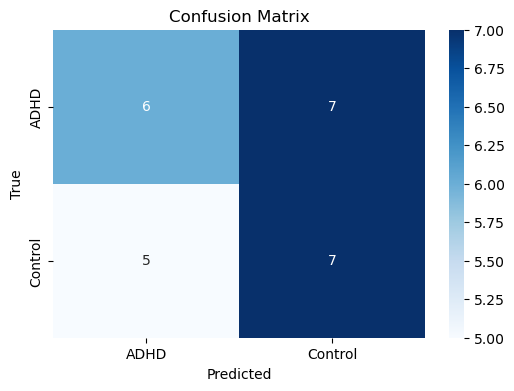

In [ ]:
# Cell 7: CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


In [ ]:
# Cell 8: Training
history = model.fit(X_train, y_train, epochs=15, batch_size=8, validation_data=(X_test, y_test))
model.save("eeg_bandpower_cnn_model.h5")


In [ ]:
# Cell 9: Evaluation
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

y_pred_probs = model.predict(X_test).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("ROC AUC:", roc_auc_score(y_test, y_pred_probs))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
# Cell 10: Visual inspection of features
plt.imshow(X_padded[0][:, :, 0].T, aspect='auto', cmap='viridis')
plt.title("EEG Band Powers Over Time (Example Patient)")
plt.xlabel("Time Window")
plt.ylabel("Feature Index")
plt.colorbar()
plt.show()
